In [1]:
!python --version

Python 3.7.16


In [1]:
from Agent import Agent

import torch

import numpy as np
import pandas as pd

import os
import sys
os.chdir("..")
from rice_nego import Rice

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def create_agent(env, state, id):
    return Agent(len(state[id]['features']), env.action_space[id], env.num_regions, id = id)

In [3]:
envs = [Rice(id = i, region_yamls_filename='2_region_yamls', num_discrete_action_levels=5) for i in range(5)]
initial_state = envs[0].reset()
agents = [create_agent(envs[0], initial_state, agent_id) for agent_id in range(envs[0].num_regions)]

In [4]:
mean_rewards = envs[0].estimate_reward_distribution(n_trials=100)
mean_rewards

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.42it/s]


array([0.0555046 , 0.05559882])

In [5]:
def step1(agents, envs, states):
    
    # Get actions in the shape [agent_id, {'proposals' : [env_id, proposal], 'promise' : [env_id, promise]}]
    actions = [agent.make_proposals([state[agent.id] for state in states]) for agent in agents]
        
    # Transform actions to [env_id, {agent_id, : {'proposals' : proposal, 'promise', 'promise'}}]
    actions = [
        [
            {
                'proposals' : actions[agent_id]['proposals'][env_id],
                'promises' : actions[agent_id]['promises'][env_id]
            }
            for agent_id in range(len(agents))
        ]
        for env_id in range(len(envs))
    ]
    
    # Pass the proposals to the environments
    states = [env.register_proposals(actions[i]) for i, env in enumerate(envs)]
    return states

In [6]:
def step2(agents, envs, states):
    
    # Get actions in the shape [agent_id, env_id, decision]
    actions = [agent.make_decisions([state[agent.id] for state in states]) for agent in agents]
    
    # Transform actions to [env_id, {agent_id : decision}]
    actions = [
        [
            actions[agent_id][env_id]
            for agent_id in range(len(agents))
        ]
        for env_id in range(len(envs))
    ]
    
    # Pass the decisions to the environments
    states = [env.register_decisions(actions[i]) for i, env in enumerate(envs)]
    return states

In [7]:
def act(agents, envs, states):
    
    actions = [
        agents[agent_id].act([state[agent_id] for state in states]) 
        for agent_id in range(len(agents))
    ]
    
    actions = [
        {
            agent_id : actions[agent_id][env_id]
            for agent_id in range(len(agents))
        }
        for env_id in range(len(envs))
    ]
    
    states, rewards, _, _ = zip(*[env.step(actions[i]) for (i, env) in enumerate(envs)])
    
    return states, rewards

In [8]:
episode_length = envs[0].episode_length
negotiation_steps = envs[0].max_negotiation_steps

# The terminal states are the same every time
is_terminals_negotiation = np.zeros(len(envs) * negotiation_steps, dtype = bool)
is_terminals_negotiation[negotiation_steps - 1 :: negotiation_steps] = True
is_terminals_negotiation = np.repeat(is_terminals_negotiation, episode_length)

all_proposal_rewards = [[] for agent in agents]
all_decision_rewards = [[] for agent in agents]

for epoch in tqdm(range(20)):
    
    for batch in range(5):
        states = [env.reset() for env in envs]
        for t in range(episode_length):
            
            for agent in agents:
                agent.reset_negotiation_hs()

            for step in range(negotiation_steps):
                states = step1(agents, envs, states)
                states = step2(agents, envs, states)
            
            states, rewards = act(agents, envs, states)
            
            rewards = np.array([list(reward.values()) for reward in rewards])
            mean_action_rewards = rewards.mean(1).reshape(1, -1) * (len(agents) - 1)

            for agent in agents:
                # Get proposal and decision rewards from envs, make them [nego_step, env_id], scale them
                # to match the order of magnitude of the environment rewards
                proposal_rewards, decision_rewards = [np.stack([
                    [env.global_negotiation_state[rs][t][step][agent.id] for env in envs]
                    for step in range(negotiation_steps)]
                ) * mean_rewards[agent.id] for rs in ('rewards_proposals', 'rewards_decisions')]

                proposal_rewards_added, decision_rewards_added = \
                    [np.where(rs != 0, rs + mean_action_rewards, rs).flatten()
                     for rs in (proposal_rewards, decision_rewards)]

                agent.nets['activityNet'].buffer.rewards.extend(rewards[:, agent.id])
                agent.nets['proposalNet'].buffer.rewards.extend(proposal_rewards_added)
                agent.nets['decisionNet'].buffer.rewards.extend(decision_rewards_added)

                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                agent.nets['proposalNet'].buffer.is_terminals.extend(is_terminals_negotiation)
                agent.nets['decisionNet'].buffer.is_terminals.extend(is_terminals_negotiation)

                all_proposal_rewards[agent.id].extend(proposal_rewards_added[proposal_rewards_added != 0])
                all_decision_rewards[agent.id].extend(decision_rewards_added[decision_rewards_added != 0])

            
    for agent in agents:
        agent.update()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.49s/it]


In [9]:
def plot_rewards(rewards, w = 100, pos = False):
    
    rewards = np.array(rewards)
    if pos:
        rewards = rewards[rewards > 0]
    plt.scatter(range(len(rewards)), rewards, alpha = .3, s = .2)
    plt.plot(np.convolve(rewards, np.ones(w) / w, mode = 'valid'), color = 'orange', linewidth = 2)
    plt.show()

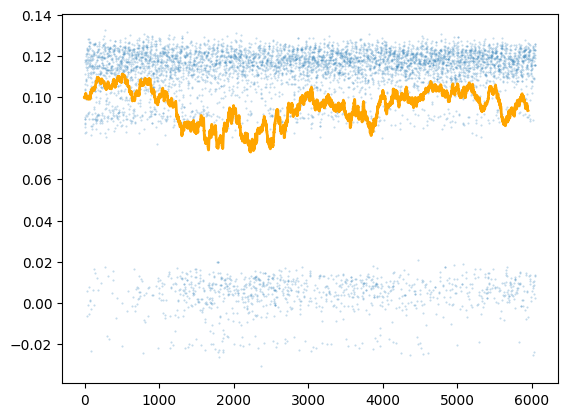

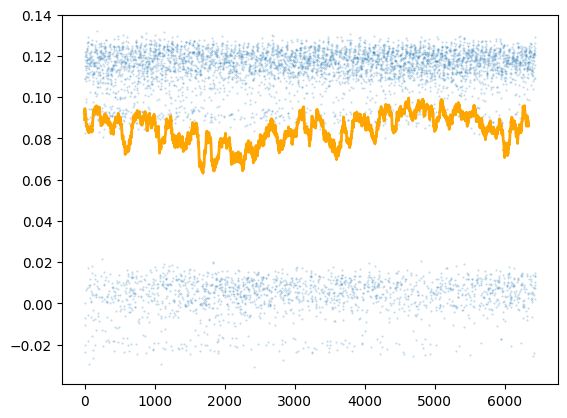

In [10]:
plot_rewards(all_decision_rewards[0])
plot_rewards(all_decision_rewards[1])


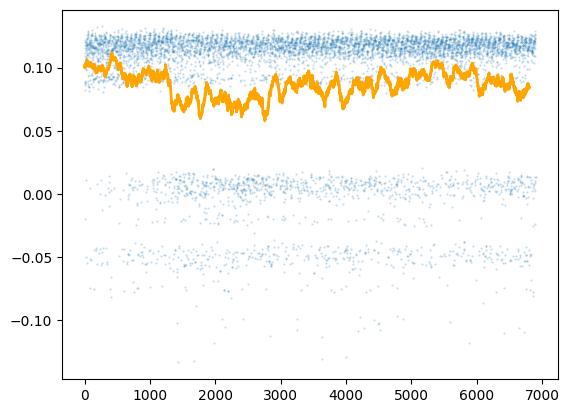

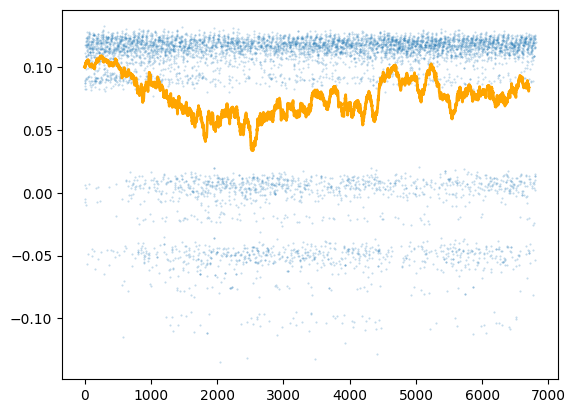

In [11]:
plot_rewards(all_proposal_rewards[0])
plot_rewards(all_proposal_rewards[1])

In [14]:
env0 = envs[0]
state = env0.reset()

for t in range(env0.episode_length):
    
    for agent in agents:
        agent.reset_negotiation_hs()
    
    for step in range(env0.max_negotiation_steps):
        
        proposals = [agent.eval_make_proposals(state[agent.id], deterministic=False) for agent in agents]
        state = env0.register_proposals(proposals)
        
        decisions = [agent.eval_make_decisions(state[agent.id], deterministic=False) for agent in agents]
        state = env0.register_decisions(decisions)
        
    actions = {agent.id: agent.eval_act(state[agent.id]) for agent in agents}
    
    state, _, _, _ = env0.step(actions)